___


___
# NLP (Natural Language Processing) with Python


In [125]:
# ONLY RUN THIS CELL IF YOU NEED 
# TO DOWNLOAD NLTK AND HAVE CONDA

# Uncomment the code below and run:


# !conda install nltk #This installs nltk
#import nltk # Imports the library
#nltk.download_shell() #Download the necessary datasets

In [34]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


In [1]:
import nltk

## Get the Data

We'll be using a dataset from the [IMDB Datasets of 50k movie reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/kernels)! This dataset is already located in the folder for this section.

Instead of parsing TSV manually using Python, we can just take advantage of pandas! Let's go ahead and import it!

In [2]:
import pandas as pd

We'll use **read_csv** and make note of the **sep** argument, we can also specify the desired column names by passing in a list of *names*.

In [4]:
messages = pd.read_csv('smsspamcollection/IMDB Dataset.csv',
                           names=["message", "label"])
messages.head()

,message,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# messages.drop(messages.iloc[0], axis='0')

## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [6]:
messages.describe()

,message,label
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [7]:
messages.groupby('label').describe()

message                                                            \
           count unique                                                top   
label                                                                        
negative   25000  24698  Nickelodeon has gone down the toilet. They hav...   
positive   25000  24884  Loved today's show!!! It was a variety and not...   

               
         freq  
label          
negative    3  
positive    5

In [8]:
messages['length'] = messages['message'].apply(len)
messages.head()

,message,label,length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


### Data Visualization
Let's visualize this! Let's do the imports:

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

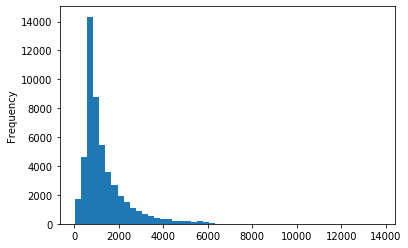

In [14]:
messages['length'].plot(bins=50, kind='hist')

In [15]:
messages.length.describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: length, dtype: float64

Woah! 13704 characters, let's use masking to find this message:

In [27]:
messages[messages['length'] == 1309]['message'].iloc[0]

'Patricia Arquette plays American doctor Laura Bowman, who takes a holiday to Burma in an attempt to heal her spirit after the murders of her husband and young son. She is left behind in Rangoon during a military crackdown and leaves the city with an aging man who works as a "tour guide." But he is no simple tour guide; he is a professor who introduces her to the life outside of the tourist traps ... the two of them get caught up in the political upheaval and Laura sees with her own eyes how the government betrays and oppresses its own people.<br /><br />This movie is one of my favorites because of its themes. First, it\'s informational (describing some of the injustices that are occurring in Burma). Secondly, it\'s about a woman\'s struggle to find meaning in life after an incredible loss. Thirdly, it\'s about compassion and sacrifice, and people coming together - without even knowing each other - to endure pain and fear.<br /><br />Just about every beautiful scene in this movie is im

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020CCD124828>,
      dtype=object)

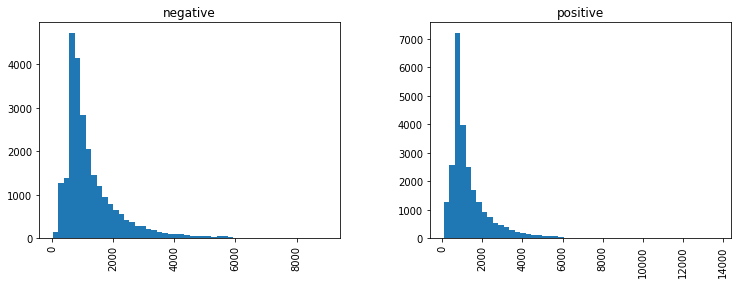

In [17]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

## Text Pre-processing

In [21]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)

Now let's see how to remove stopwords. We can impot a list of english stopwords from NLTK (check the documentation for more languages and info).

In [23]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [17]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [18]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [19]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

Now let's put both of these together in a function to apply it to our DataFrame later on:

In [55]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Remove the html parser or tag
    nopunc = BeautifulSoup(mess, "html.parser").get_text()
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in nopunc if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    pattern=r'[^a-zA-z0-9\s]'
    nopunc=re.sub(pattern,'',nopunc)
    
    #Removing the square brackets
    nopunc = re.sub('\[[^]]*\]', '', nopunc)
    
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Here is the original DataFrame again:

In [19]:
messages.head()

,message,label,length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

Let's see an example output on on column:


In [54]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [One, reviewers, mentioned, watching, 1, Oz, e...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, way, spend, time, hot, su...
3    [Basically, theres, family, little, boy, Jake,...
4    [Petter, Matteis, Love, Time, Money, visually,...
Name: message, dtype: object

In [56]:
# Show original dataframe
messages.head()

,message,label,length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


## Vectorization

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [58]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

255985


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [59]:
message4 = messages['message'][3]
print(message4)

Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.


Now let's see its vector representation:

In [60]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 94)	1
  (0, 10560)	1
  (0, 11827)	1
  (0, 25694)	1
  (0, 45831)	4
  (0, 66400)	1
  (0, 71415)	1
  (0, 103503)	1
  (0, 107988)	1
  (0, 112307)	1
  (0, 120329)	2
  (0, 128950)	1
  (0, 130210)	1
  (0, 131063)	1
  (0, 133613)	1
  (0, 135100)	3
  (0, 142457)	1
  (0, 144165)	1
  (0, 146122)	1
  (0, 146252)	2
  (0, 147744)	1
  (0, 154123)	1
  (0, 164118)	1
  (0, 166911)	1
  (0, 171367)	1
  :	:
  (0, 184839)	3
  (0, 186798)	1
  (0, 193599)	1
  (0, 196824)	2
  (0, 200716)	1
  (0, 208204)	1
  (0, 213944)	1
  (0, 217495)	1
  (0, 220882)	1
  (0, 221902)	1
  (0, 223429)	1
  (0, 224221)	1
  (0, 226754)	1
  (0, 230842)	1
  (0, 236141)	2
  (0, 236636)	1
  (0, 237474)	2
  (0, 238266)	1
  (0, 239954)	1
  (0, 249303)	1
  (0, 249335)	1
  (0, 250322)	1
  (0, 255541)	1
  (0, 255866)	1
  (0, 255869)	1
(1, 255985)


This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice:

In [61]:
print(bow_transformer.get_feature_names()[94])
print(bow_transformer.get_feature_names()[45831])

10
Jake


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire reviews corpus is a large, sparse matrix:

In [62]:
messages_bow = bow_transformer.transform(messages['message'])

In [63]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (50000, 255985)
Amount of Non-Zero occurences:  5044600


In [65]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

____
### TF-IDF

In [66]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 255869)	0.20343709565307747
  (0, 255866)	0.1056718277336957
  (0, 255541)	0.06997547984835885
  (0, 250322)	0.044712404685969584
  (0, 249335)	0.06479141818546483
  (0, 249303)	0.10084136454306664
  (0, 239954)	0.07466160119556126
  (0, 238266)	0.15110528179751925
  (0, 237474)	0.17298473500116945
  (0, 236636)	0.09321745611200966
  (0, 236141)	0.13849727240191861
  (0, 230842)	0.09291162731234284
  (0, 226754)	0.20343709565307747
  (0, 224221)	0.10731027555858091
  (0, 223429)	0.13741591408219006
  (0, 221902)	0.08272932579439594
  (0, 220882)	0.08188045737655504
  (0, 217495)	0.039590739770570725
  (0, 213944)	0.12056410286702753
  (0, 208204)	0.0545084161004045
  (0, 200716)	0.07169094139974093
  (0, 196824)	0.17326025560556302
  (0, 193599)	0.10528417151030094
  (0, 186798)	0.05979397956713852
  (0, 184839)	0.08338804296858891
  :	:
  (0, 171367)	0.07896239976843385
  (0, 166911)	0.07071954269076997
  (0, 164118)	0.1119461075918524
  (0, 154123)	0.05545532474394398
  (0, 147

We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?

In [71]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

6.643648551636456
7.245087305706903


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [72]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(50000, 255985)


## Training a model

With messages represented as vectors, we can finally train our pos/neg classifier. Now we use  the Naive Bayes classifier algorithm.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [73]:
from sklearn.naive_bayes import MultinomialNB
neg_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

Let's try classifying our single random message and checking how we do:

In [74]:
print('predicted:', neg_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: negative
expected: negative


Fantastic! We've developed a model that can attempt to predict spam vs ham classification!

## Part 6: Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [75]:
all_predictions = neg_detect_model.predict(messages_tfidf)
print(all_predictions)

['positive' 'positive' 'positive' ... 'negative' 'negative' 'negative']


In [76]:
from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

    negative       0.92      0.93      0.92     25000
    positive       0.93      0.91      0.92     25000

    accuracy                           0.92     50000
   macro avg       0.92      0.92      0.92     50000
weighted avg       0.92      0.92      0.92     50000



In the above "evaluation",we evaluated accuracy on the same data we used for training. **You should never actually evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.

## Train Test Split

In [77]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

40000 10000 50000


The test size is 20% of the entire dataset.

## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [78]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [79]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000020CDBCD30D0>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [80]:
predictions = pipeline.predict(msg_test)

In [136]:
msg_new = [line.rstrip() for line in open('checkfolder/checkMsg')]

In [137]:
predictions = pipeline.predict(msg_new)

In [138]:
predictions[:20]

array(['positive', 'negative', 'negative', 'negative'], dtype='<U8')

In [ ]:
print(classification_report(predictions,label_test))

# Happy Ending!